In [2]:
# #only run once
# #!pip install nes-py==0.2.6
# !brew update
# !brew install ffmpeg
# !brew install libsm
# !brew install libxext
# !brew install mesa
# !pip install opencv-python
# !pip install gym-super-mario-bros
# !pip install gym

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

In [2]:
import torch
import torchvision
import torch.nn as nn
import random
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import SuperMarioBrosEnv
from tqdm import tqdm
import pickle 
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
import datetime
import json
from toolkit.gym_env import *
from toolkit.action_utils import *
from toolkit.marlios_model import *
from toolkit.constants import *
import warnings
from torchvision import models

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [9]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    display(plt.gcf(), clear=True)

def make_env(env, actions=ACTION_SPACE):
    env = MaxAndSkipEnv(env, skip=2) # I am testing out fewer fram repetitions for our two actions modelling
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, actions)

def generate_epoch_time_id():
    epoch_time = int(time.time())
    return str(epoch_time)

def save_checkpoint(agent, total_rewards, terminal_info, run_id):
    with open(f"experiments/ending_position-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.ending_position, f)
    with open(f"experiments/num_in_queue-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.num_in_queue, f)
    with open(f"experiments/total_rewards-{run_id}.pkl", "wb") as f:
        pickle.dump(total_rewards, f)
    with open(f"experiments/terminal_info-{run_id}.pkl", "wb") as f:
        pickle.dump(terminal_info, f)
    if agent.double_dq:
        torch.save(agent.local_net.state_dict(), f"dq1-{run_id}.pt")
        torch.save(agent.target_net.state_dict(), f"dq2-{run_id}.pt")
    else:
        torch.save(agent.dqn.state_dict(), f"dq-{run_id}.pt")  

def load_rewards(from_file):
     with open(from_file, 'rb') as f:
        total_rewards = pickle.load(f)
        return total_rewards

def load_loss(from_file):
     with open(from_file, 'rb') as f:
        total_loss = pickle.load(f)
        return total_loss

def plot_loss(ep_per_stat = 100, total_loss = [], from_file = None):
    if from_file != None:
        total_loss = load_loss(from_file)
       
    # avg_loss = [np.mean(total_loss[i:i+ep_per_stat]) for i in range(0, len(total_loss), ep_per_stat)]
    # std_loss = [np.std(total_loss[i:i+ep_per_stat]) for i in range(0, len(total_loss), ep_per_stat)]

    fig, ax = plt.subplots()
    # ax.plot(avg_loss, label='Average loss')
    ax.plot(total_loss, label='Loss')
    # ax.fill_between(range(len(avg_loss)), np.subtract(avg_loss, std_loss), np.add(avg_loss, std_loss), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Loss')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(total_loss) // ep_per_stat + 1)]
    plt.xticks(range(0, len(total_loss), ep_per_stat), xtick_labels)
    ax.legend(loc='lower right')
    plt.show()

def plot_rewards(ep_per_stat = 100, total_rewards = [], from_file = None, tick_freq = 2):
    if from_file != None:
        total_rewards = load_rewards(from_file)

    total_rewards = total_rewards[:len(total_rewards) - 2]
       
    avg_rewards = [np.mean(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]
    std_rewards = [np.std(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]

    fig, ax = plt.subplots()
    ax.plot(avg_rewards, label='Average Rewards')
    ax.fill_between(range(len(avg_rewards)), np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(avg_rewards))]
    plt.xticks(range(1, len(avg_rewards)+1), xtick_labels)
    plt.xticks(rotation=45)
    fig.suptitle("Average Rewards per Episode for MaRLios Model", fontsize=13, fontweight="bold")
    ax.set_title("Avg. and Std. Dev per 100 episodes", fontsize=11, pad=16, y=0.97)
    
    ax.legend(loc='lower right')
    plt.show()

# define the run function with some helpful debugging stats

def run(training_mode=True, pretrained=False, lr=0.0001, gamma=0.90, exploration_decay=0.995, exploration_min=0.02, 
        ep_per_stat = 100, exploration_max = 1, lr_decay = 0.999,
        mario_env='SuperMarioBros-1-1-v0', action_space=TWO_ACTIONS_SET, num_episodes=1000, run_id=None, n_actions=5, debug = True):
   
    run_id = run_id or generate_epoch_time_id()
    fh = open(f'experiments/progress-{run_id}.txt', 'a')
    env = gym.make(mario_env)
    env = make_env(env, ACTION_SPACE)

    # observation_space = env.observation_space.shape # not using this anymore

    #todo: add agent params as a setting/create different agents in diff functions to run 
    exploration_max = min(1, max(exploration_max, exploration_min))

    agent = DQNAgent(
                     state_space=env.observation_space.shape,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=64,
                     gamma=gamma,
                     lr=lr,
                     dropout=None,
                     exploration_max=exploration_max,
                     exploration_min=exploration_min,
                     exploration_decay=exploration_decay,
                     delay_decay=delay_decay,
                     double_dq=True,
                     pretrained=pretrained,
                     run_id=run_id,
                     n_actions=n_actions,
                     sample_actions = sample_actions)
    
    
    # num_episodes = 10
    env.reset()
    total_rewards = []
    total_info = []
    total_losses = []
    if pretrained:
        total_rewards = load_rewards(from_file='experiments/total_rewards-{}.pkl'.format(run_id))
        # total_loss = load_loss(from_file='total_loss-{}.pkl'.format(run_id))
    
    offset = len(total_rewards)   
    for iteration in tqdm(range(num_episodes)):
        ep_num = offset + iteration

        state = env.reset() # take the final dimension of shape 
        state = torch.Tensor([state])# converts (1, 84, 84) to (1, 1, 84, 84)
        total_reward = 0
        steps = 0

        action_freq = {}
        while True:
            if not training_mode:
                show_state(env, ep_num)


            two_actions_index = agent.act(state)
            two_actions_vector = agent.cur_action_space[0, two_actions_index[0]]
            two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions

            # debugging info
            key = " | ".join([",".join(i) for i in two_actions])
            if key in action_freq:
                action_freq[key] += 1
            else:
                action_freq[key] = 1
            
            steps += 1
            reward = 0
            info = None
            terminal = False
            for action in two_actions: 
                if not terminal:
                    # compute index into ACTION_SPACE of our action
                    step_action = ACTION_TO_INDEX[action]

                    state_next, cur_reward, terminal, info = env.step(step_action)
                    total_reward += cur_reward
                    reward += cur_reward
                    
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)        
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, two_actions_index, reward, state_next, terminal)
                loss = agent.experience_replay(debug=debug)
                if loss != None:
                    return loss 
                total_losses.append(loss)
            
            state = state_next
            if terminal:
                break

        total_info.append(info)
        total_rewards.append(total_reward)

        # decay LR
        # agent.decay_exploration()
        agent.decay_lr(lr_decay)
        
        if training_mode and (ep_num % ep_per_stat) == 0 and ep_num != 0:
            save_checkpoint(agent, total_rewards, total_info, run_id)

        with open(f'experiments/total_reward-{run_id}.txt', 'a') as f:
            f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
            if (ep_num%100 == 0):
                f.write("==================\n")
                f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
                f.write("==================\n")
            #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
            num_episodes += 1
        
        with open(f'experiments/actions_chosen-{run_id}.txt', 'a') as f:
            f.write("Action Frequencies for Episode {}, Exploration = {:4f}\n".format(ep_num + 1, agent.exploration_rate))
            f.write(json.dumps(action_freq) + "\n\n")
        
        if debug:
            with open(f'loss-{run_id}.txt', 'a') as f:
                f.write("loss: {}".format(loss))
    
    if training_mode:
        save_checkpoint(agent, total_rewards, total_info, run_id)
        
    
    env.close()
    fh.close()
    
    if num_episodes > ep_per_stat:
        plot_rewards(ep_per_stat=ep_per_stat, total_rewards=total_rewards)


In [10]:
# # rerunning fresh
# run(training_mode=True, 
#     pretrained=False, # use the pretrained model
#     ep_per_stat=100, 
#     num_episodes=3000,
#     lr=0.001,
#     exploration_min=0.02,
#     exploration_max = 1, # setting this to the min for the rerun model
#     exploration_decay=0.9995, 
#     action_space=SIMPLE_MOVEMENT,
#     n_actions=len(SIMPLE_MOVEMENT)+2)

loss = run(training_mode=True, 
    pretrained=False, # use the pretrained model
    ep_per_stat=200, 
    gamma=0.7,
    num_episodes=6000,
    run_id=None,
    lr=0.00025,
    lr_decay= 0.999,
    exploration_min=0.02,
    exploration_max = 1, # setting this to the min for the rerun model
    exploration_decay=0.995, 
    action_space=SIMPLE_MOVEMENT,
    n_actions=len(SIMPLE_MOVEMENT),
    debug=True
    )


# #rerunning pretrained
# run_id = '1682047848'
# run(training_mode=True, 
#     pretrained=True, # use the pretrained model
#     ep_per_stat=100, 
#     num_episodes=1000,
#     run_id=run_id,
#     lr=0.0001,
#     exploration_min=0.02,
#     exploration_max = 0.5, # setting this to the min for the rerun model
#     exploration_decay=0.995, 
#     action_space=SIMPLE_MOVEMENT,
#     n_actions=len(SIMPLE_MOVEMENT)
#     )

  0%|          | 0/6000 [00:01<?, ?it/s]


In [20]:
loss
torch.mean(loss).cpu().data.numpy().item(0)

3.1464223861694336

In [ ]:
def visualize(run_id, action_space, n_actions, lr=0.0001, exploration_min=0.02, ep_per_stat = 100, exploration_max = 0.1, mario_env='SuperMarioBros-1-1-v0',  num_episodes=1000, log_stats = False):
   
   
    fh = open(f'progress-{run_id}.txt', 'a')
    env = gym.make(mario_env)
    env = make_env(env, ACTION_SPACE)


    # observation_space = env.observation_space.shape # not using this anymore

    #todo: add agent params as a setting/create different agents in diff functions to run 
    exploration_max = min(1, max(exploration_max, exploration_min))

    agent = DQNAgent(
                     state_space=env.observation_space.shape,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=64,
                     gamma=0.9,
                     lr=lr,
                     dropout=None,
                     exploration_max=exploration_max,
                     exploration_min=exploration_min,
                     exploration_decay=0.9995,
                     double_dq=True,
                     pretrained=True,
                     run_id=run_id,
                     n_actions=n_actions)
    
    
    # num_episodes = 10
    env.reset()
    total_rewards = []
    total_info = []
 
    for ep_num in tqdm(range(num_episodes)):
      
        state = env.reset() # take the final dimension of shape 
        state = torch.Tensor([state])# converts (1, 84, 84) to (1, 1, 84, 84)
        total_reward = 0
        steps = 0

        action_freq = {}
        while True:

            show_state(env, ep_num)

            two_actions_index = agent.act(state)
            two_actions_vector = agent.cur_action_space[0, two_actions_index[0]]
            two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions
            
            print(two_actions)

            # debugging info
            key = " | ".join([",".join(i) for i in two_actions])
            if key in action_freq:
                action_freq[key] += 1
            else:
                action_freq[key] = 1
            
            steps += 1
            reward = 0
            info = None
            terminal = False
            for action in two_actions: 
                if not terminal:
                    # compute index into ACTION_SPACE of our action
                    step_action = ACTION_TO_INDEX[action]

                    state_next, cur_reward, terminal, info = env.step(step_action)
                    total_reward += cur_reward
                    reward += cur_reward
                    
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)        
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            
            state = state_next
            if terminal:
                break

        total_info.append(info)
        total_rewards.append(total_reward)

        if log_stats:
            with open(f'visualized_rewards-{run_id}.txt', 'a') as f:
                f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
                if (ep_num%100 == 0):
                    f.write("==================\n")
                    f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
                    f.write("==================\n")
                #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
                num_episodes += 1
            
            with open(f'visualized_actions_chosen-{run_id}.txt', 'a') as f:
                f.write("Action Frequencies for Episode {}, Exploration = {:4f}\n".format(ep_num + 1, agent.exploration_rate))
                f.write(json.dumps(action_freq) + "\n\n")
        
    
    env.close()
    fh.close()
    
    if num_episodes > ep_per_stat:
        plot_rewards(ep_per_stat=ep_per_stat, total_rewards=total_rewards)

In [ ]:
run_id = '1682062196' # left left guy
visualize(run_id=run_id, action_space=SIMPLE_MOVEMENT, n_actions=len(SIMPLE_MOVEMENT), ep_per_stat=200, num_episodes=100, exploration_max=0.02)

In [ ]:
# Visualizing this specific run
action_space=SIMPLE_MOVEMENT
action_space.append([['A', 'B', 'down', 'right'], ['A']])

run_id = '1681968442'
# setting it to sample all the dif actions 
visualize(run_id=run_id, action_space=action_space, n_actions=len(action_space)+1, ep_per_stat=100, num_episodes=500, exploration_max=0.02)

In [ ]:
action_space=SIMPLE_MOVEMENT
action_space.append([['A', 'B', 'down', 'right'], ['A']])

In [ ]:
action_space

In [36]:
run(training_mode=True, 
    pretrained=False, # use the pretrained model
    ep_per_stat=100, 
    num_episodes=3000,
    lr=0.00001,
    gamma=0.95,
    exploration_min=0.02,
    exploration_max = 1, # setting this to the min for the rerun model
    exploration_decay=0.9995, 
    action_space=SIMPLE_MOVEMENT,
    n_actions=len(SIMPLE_MOVEMENT)+2)

  1%|▏         | 42/3000 [13:51<16:15:37, 19.79s/it]


KeyboardInterrupt: 

In [ ]:
# Run with pretrained model

run(training_mode=False, 
    pretrained=True, # use the pretrained model
    ep_per_stat=100, 
    num_episodes=10,
    run_id='marlios_run_norm_lr_0_001',
    lr=0.00001,
    exploration_min=0.02,
    exploration_max = 0.02, # setting this to the min for the rerun model
    exploration_decay=0.9995, 
    action_space=SIMPLE_MOVEMENT,
    n_actions=len(SIMPLE_MOVEMENT)+2)

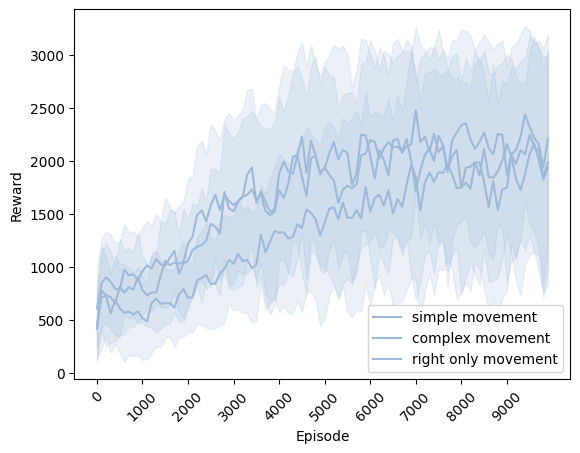

In [48]:
from matplotlib.cm import PuBu, YlGn

def plot_rewards(ep_per_stat = 100, total_rewards = [], from_file = None, ax=None, n_ticks=10, label='Average Rewards', color=YlGn):
    if from_file != None:
        total_rewards = load_rewards(from_file)

    if ax is None:
        fig,ax = plt.subplots()
       
    avg_rewards = [np.mean(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]
    std_rewards = [np.std(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]

    ax.plot(avg_rewards, label=label, color=color)
    ax.fill_between(range(len(avg_rewards)), np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), alpha=0.2, color=color)

    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(avg_rewards))]
    xtick_labels = xtick_labels[::n_ticks]
    plt.xticks(range(0, len(avg_rewards), n_ticks), xtick_labels)
    plt.xticks(rotation=45)
    ax.legend(loc='lower right')

action_sets = ['simple_movement', 'complex_movement', 'right_only_movement']

fig, axi = plt.subplots()

i = 1
for action in action_sets:

    fname = "trained_models/default_{}/total_rewards-default_{}_10000ep_x.pkl".format(action.split('_')[0], action)
    action_label = " ".join(action.split('_'))
    plot_rewards(from_file=fname, ax=axi, label=action_label, color=PuBu(i*100))
    i+=1
    

ValueError: <matplotlib.colors.LinearSegmentedColormap object at 0x160af1090> is not a valid value for color

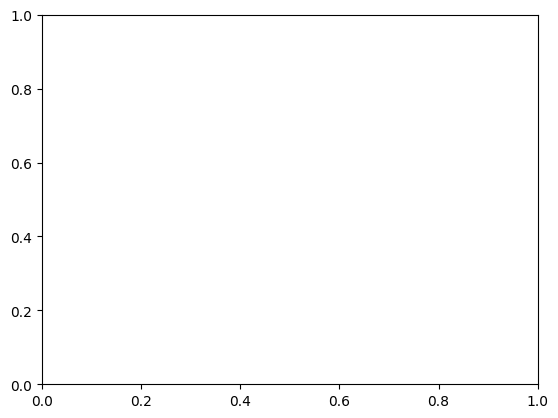

In [49]:
action_sets = ['right_only_movement', 'simple_movement', 'complex_movement',]

fig, axi = plt.subplots()

for action in action_sets:

    fname = "trained_models/default_{}/total_rewards-default_{}_10000ep_x.pkl".format(action.split('_')[0], action)
    action_label = " ".join(action.split('_'))
    plot_rewards(from_file=fname, ax=axi, label=action_label)
    
plt.suptitle("Episodes trained vs. Average Rewards (per 100 eps)")
plt.title("for Baseline models trained on three different action sets")

In [ ]:
plot_

In [11]:
plot_rewards(ep_per_stat=100, from_file='./total_rewards-marlios_run_two_action_set_lr_0_0001.pkl', tick_freq=3)

FileNotFoundError: [Errno 2] No such file or directory: './total_loss-marlios_run_norm_lr_0_001.pkl'

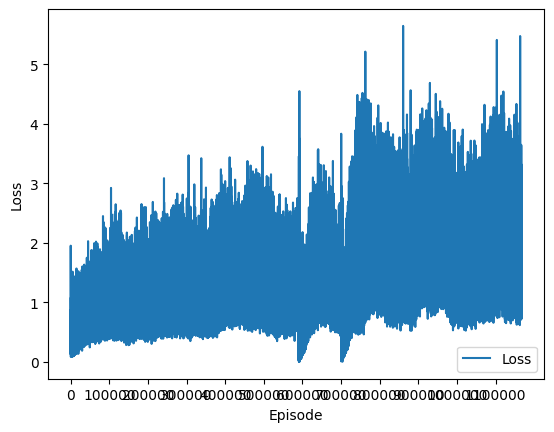

In [98]:
plot_loss(ep_per_stat=100000, from_file='./total_loss-marlios_run_two_action_set_lr_0_0001.pkl')

# Debugging

In [14]:
x = torch.randn(2, 3, 5)
reshaped_input = x.view(-1, x.shape[-1])
final = reshaped_input.view(x.shape[0], x.shape[1], -1)


In [15]:
print(x)
print(reshaped_input)
print(final)

tensor([[[-0.3939,  0.9087,  0.0522, -0.7961,  0.2194],
         [-2.1833, -0.5012, -1.5120,  1.1976, -1.4270],
         [-1.4877,  0.4767,  0.2844,  0.6696, -0.1502]],

        [[ 0.9327,  2.3834, -0.3934,  0.6228,  0.9853],
         [-0.8383,  0.4333,  0.4330, -0.3917,  0.4475],
         [ 1.0167, -0.6274, -1.3792, -0.0133, -1.2329]]])
tensor([[-0.3939,  0.9087,  0.0522, -0.7961,  0.2194],
        [-2.1833, -0.5012, -1.5120,  1.1976, -1.4270],
        [-1.4877,  0.4767,  0.2844,  0.6696, -0.1502],
        [ 0.9327,  2.3834, -0.3934,  0.6228,  0.9853],
        [-0.8383,  0.4333,  0.4330, -0.3917,  0.4475],
        [ 1.0167, -0.6274, -1.3792, -0.0133, -1.2329]])
tensor([[[-0.3939,  0.9087,  0.0522, -0.7961,  0.2194],
         [-2.1833, -0.5012, -1.5120,  1.1976, -1.4270],
         [-1.4877,  0.4767,  0.2844,  0.6696, -0.1502]],

        [[ 0.9327,  2.3834, -0.3934,  0.6228,  0.9853],
         [-0.8383,  0.4333,  0.4330, -0.3917,  0.4475],
         [ 1.0167, -0.6274, -1.3792, -0.0133, -

In [22]:
loss = load_loss('./total_loss-marlios_run_no_sample_lr_0_0001.pkl')

In [27]:
len(loss)
loss[0:30]


[5.141533851623535,
 4.460992813110352,
 5.295253276824951,
 4.35986328125,
 4.543642997741699,
 4.190987586975098,
 4.922931671142578,
 4.466704368591309,
 4.584052562713623,
 4.102752685546875,
 4.795726776123047,
 3.8813600540161133,
 3.81713604927063,
 3.7155098915100098,
 3.357593536376953,
 4.106273174285889,
 3.3816332817077637,
 3.2348928451538086,
 3.6818108558654785,
 3.72611927986145,
 3.2683355808258057,
 3.420872688293457,
 3.653456211090088,
 3.613271713256836,
 3.689671516418457,
 3.6937150955200195,
 3.4634366035461426,
 3.5722179412841797,
 3.4611191749572754,
 3.5614728927612305]